# Data Analytics Report

In this workbook we investigate the BindingDB dataset and do the following:
- Create a new column using the IC50 and Ki data to describe if the molecule is a good degrader of the target protein.
- Filter the data on a target protein basis to decide which protein has the best data associated with it and then investigate these target proteins (we choose  Dimer of Gag-Pol polyprotein and Coagulation factor X as exemplars).
- Determine using RF what features of a molecule are best at determining if a molecule is a good inhibitor.
- Fit ensemble model using only these features and evaluate the model's performance.
- Investigate if there are any molecules that aren't targeting the protein that perhaps should be (using the model to predict their effectiveness).

Note that this workbook needs to be in the same folder as the BindingsDB dataset as well as the relevant featurisations.


In [1]:
# Python ≥ 3.7 is required
import sys
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥ 1.0.1 is required
import sklearn
assert sklearn.__version__ >= '1.0.1'
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, StackingClassifier
import sklearn.metrics as metrics
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_score, silhouette_samples, mean_squared_error, r2_score, classification_report, confusion_matrix

# TensorFlow ≥ 2.0 is required
import tensorflow as tf
print('Tensorflow version:', tf.__version__)

# Keras ≥ 2.4 is required
from tensorflow import keras
#print('Keras version:', keras.__version__) 

#Torch
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

# Sci-kit Learn
from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd

# RDKit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from rdkit.Chem import RDKFingerprint, rdMolDescriptors, Draw, Descriptors

Tensorflow version: 2.14.0


In [2]:
df = pd.read_csv('./BindingDB_BindingDB_Articles_202310.tsv', sep = '\t', usecols = range(50), dtype = str)

In [3]:
list(df.columns.values)

['BindingDB Reactant_set_id',
 'Ligand SMILES',
 'Ligand InChI',
 'Ligand InChI Key',
 'BindingDB MonomerID',
 'BindingDB Ligand Name',
 'Target Name',
 'Target Source Organism According to Curator or DataSource',
 'Ki (nM)',
 'IC50 (nM)',
 'Kd (nM)',
 'EC50 (nM)',
 'kon (M-1-s-1)',
 'koff (s-1)',
 'pH',
 'Temp (C)',
 'Curation/DataSource',
 'Article DOI',
 'BindingDB Entry DOI',
 'PMID',
 'PubChem AID',
 'Patent Number',
 'Authors',
 'Institution',
 'Link to Ligand in BindingDB',
 'Link to Target in BindingDB',
 'Link to Ligand-Target Pair in BindingDB',
 'Ligand HET ID in PDB',
 'PDB ID(s) for Ligand-Target Complex',
 'PubChem CID of Ligand',
 'PubChem SID of Ligand',
 'ChEBI ID of Ligand',
 'ChEMBL ID of Ligand',
 'DrugBank ID of Ligand',
 'IUPHAR_GRAC ID of Ligand',
 'KEGG ID of Ligand',
 'ZINC ID of Ligand',
 'Number of Protein Chains in Target (>1 implies a multichain complex)',
 'BindingDB Target Chain Sequence',
 'PDB ID(s) of Target Chain',
 'UniProt (SwissProt) Recommended Na

In [4]:
temp_df = df[['Ligand SMILES', 'Target Name', 'IC50 (nM)', 'EC50 (nM)', 'Ki (nM)', 'Kd (nM)']]
# temp_df.fillna(10000, inplace=True)
temp_df.isna().sum()

Ligand SMILES        0
Target Name          0
IC50 (nM)        28774
EC50 (nM)        85168
Ki (nM)          65483
Kd (nM)          87146
dtype: int64

In [5]:
df.shape[0]

89697

Given that for Kd and EC50 most cells have NaN, it is not worth considering them. We will focus exclusively on IC50 and Ki to determine if a molecule is an effective degrader.

Let's compare the different featurisations. There are three: morgan_fingerprint, rd_kit and mordred descriptors:

In [6]:
morgan_fingerprints = pd.read_csv('morgan_fingerprints.csv', header=0)
print('Morgan Fingerprints featurisation has ', len(morgan_fingerprints.columns), 'features')
rdkit_descriptors = pd.read_csv('rdkit_descriptors.csv', header=0)
print('RD Kit featurisation has ', len(rdkit_descriptors.columns), 'features')
mordred_descriptors = pd.read_csv('mordred_descriptors.csv', header=0)
print('Mordred featurisation has ', len(mordred_descriptors.columns), 'features')

Morgan Fingerprints featurisation has  2050 features
RD Kit featurisation has  212 features
Mordred featurisation has  835 features


The best featurisations to start with is the rdkit. This is because there aren't too many (compared to the mordred descriptors and Morgan Fingerprints) and they have a physical realization, which will help when writing up the report. We wish to be able to understand why some molecules are better predictors than others so abstract vector components (like in the case of Morgan Fingerprints) are less helpful. We create a new df that has only the columns we want, i.e. Ligand SMILES, Target Name, IC50 and Ki. We also create crate a now column/catgory called "Effective" that uses the IC50 or the Ki to determine if a molecule is a good inhibitor. We primarily want the IC50, but in the event that the IC50 isn't there and the Ki is we use this instead as they are related.

In [7]:
def createNewCategory(ic50=10, ki=50, extra=True):
    def removeInequalityIC50(row):
        if ((row['IC50 (nM)'][0] in ['>', '<'])):
            return row['IC50 (nM)'][1:]
        else:
            return row['IC50 (nM)']
    def removeInequalityKi(row):
        if ((row['Ki (nM)'][0] in ['>', '<'])):
            return row['Ki (nM)'][1:]
        else:
            return row['Ki (nM)']
    temp_df = None #The following check is because we've used the function in different ways.
    if (extra):
        temp_df = df[['Ligand SMILES', 'Target Name', 'IC50 (nM)', 'Ki (nM)']]
    else:
        temp_df = df[['BindingDB Ligand Name', 'Ligand SMILES', 'Target Name', 'IC50 (nM)', 'Ki (nM)']]
    temp_df.dropna(subset=['IC50 (nM)', 'Ki (nM)'], how='all') #Drop a row if both IC50 and Ki are NaN.
    temp_df = temp_df.fillna('10000') #Since only one of IC50 and Ki can be Nan, we give a large value so we can still use the other. 
    temp_df['IC50 (nM)'] = temp_df.apply(removeInequalityIC50, axis=1)
    temp_df['Ki (nM)'] = temp_df.apply(removeInequalityKi, axis=1)
    temp_df['IC50 (nM)'] = temp_df['IC50 (nM)'].astype(float) #Convert IC50 to a float
    temp_df['Ki (nM)'] = temp_df['Ki (nM)'].astype(float) #Convert Ki to a float
    #Add a new category variable. Good or bad protein degrader.
    temp_df['Effective'] = np.where((temp_df['IC50 (nM)']<= ic50) 
                                    | (temp_df['Ki (nM)']<= ki),
                                    1, 0)
    if (extra):
        temp_df.drop(['IC50 (nM)', 'Ki (nM)'], axis=1, inplace=True)   
    return temp_df


In [8]:
protDF = createNewCategory(10,5)

In [9]:
counts = protDF['Target Name'].value_counts() 
counts[counts>1000]

Replicase polyprotein 1ab                                          4474
Acetylcholinesterase                                               1889
Dimer of Gag-Pol polyprotein [489-587]                             1675
Vascular endothelial growth factor receptor 2                      1323
Carbonic anhydrase 2                                               1284
Coagulation factor X                                               1273
cAMP and cAMP-inhibited cGMP 3',5'-cyclic phosphodiesterase 10A    1219
Epidermal growth factor receptor                                   1214
Gag-Pol polyprotein [588-1027]/[588-1147]                          1090
Name: Target Name, dtype: int64

In [10]:
targ_df = protDF[['Effective', 'Target Name']]
targ_df = targ_df.groupby(['Target Name']).agg({'Effective': [('Total', "count"), ('Count 0', lambda x: (x==0).sum()), ('Count 1', lambda x: (x==1).sum()) ]})
targ_df.columns = list(map(''.join, targ_df.columns.values))
targ_df
targ_df.sort_values(['EffectiveTotal'], ascending=[False], inplace = True)
targ_df.drop('EffectiveTotal', axis=1, inplace=True)

<Figure size 1200x5000 with 0 Axes>

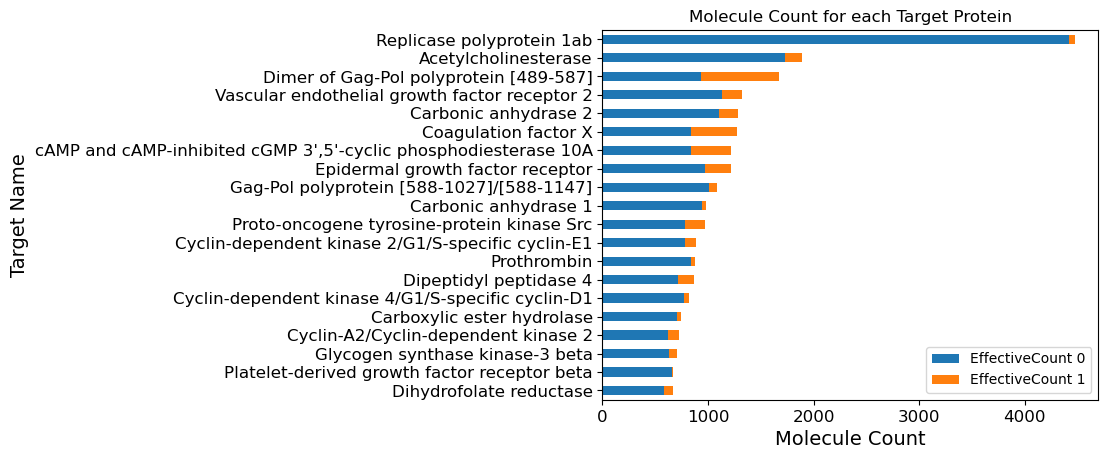

In [11]:
plt.figure(figsize=(12,50))
ax = targ_df.head(20).plot(kind='barh', stacked=True)
ax.invert_yaxis()
plt.title("Molecule Count for each Target Protein")
plt.xlabel("Molecule Count")
plt.show()

## Target Protein: Dimer of Gag-Pol polyprotein [489-587]
As we have more than 1000 molecules targeting it and the data is balanced, we choose to investigate what features of a molecule are important for degrading the target protein Dimer of Gag-Pol polyprotein [489-587].

In [ ]:
def joinRDKitFeatures(old_df, target_protein):
    temp_df=old_df.loc[old_df['Target Name'] == target_protein]
    rdkit_descriptors = pd.read_csv('rdkit_descriptors.csv', header=0)
    rdkit_descriptors.drop('Unnamed: 0', axis=1, inplace = True)
    rdkit_descriptors = pd.merge(rdkit_descriptors, temp_df, left_on='SMILES', right_on='Ligand SMILES')
    rdkit_descriptors.drop(['SMILES', 'Ligand SMILES', 'Target Name'], axis=1, inplace=True)   
    #We need to convert the float64 columns to float32 as random forest won't work on this.
    float64_cols = list(rdkit_descriptors.select_dtypes(include='float64'))
    # The same code again calling the columns
    rdkit_descriptors[float64_cols] = rdkit_descriptors[float64_cols].astype('float32')
    rdkit_descriptors.replace([-np.inf, np.inf], np.nan, inplace=True)
    rdkit_descriptors.dropna(inplace=True)
    return rdkit_descriptors

In [ ]:
dimerDF = joinRDKitFeatures(protDF, 'Dimer of Gag-Pol polyprotein [489-587]')
dimerDF

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Effective
0,13.312152,13.312152,0.080743,-1.035691,0.204142,17.024391,573.778992,522.370972,573.389038,230,...,0,0,0,0,0,0,0,0,0,1
1,13.502263,13.502263,0.029655,-1.093548,0.163114,16.400000,633.830994,578.390991,633.410156,254,...,0,0,0,0,0,0,0,0,0,0
2,13.636480,13.636480,0.001938,-1.125943,0.095098,16.040817,693.882996,634.411011,693.431274,278,...,0,0,0,0,0,0,0,2,0,0
3,13.781727,13.781727,0.001466,-1.147600,0.064850,15.600000,781.989014,714.453003,781.483704,314,...,0,0,0,0,0,0,0,8,0,0
4,13.838322,13.838322,0.053081,-1.362978,0.113449,15.653846,717.867981,666.460022,717.385010,280,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,14.060056,14.060056,0.009325,-4.093373,0.198178,15.729167,698.911987,652.544006,698.292053,260,...,1,0,0,0,1,0,0,0,1,0
916,13.824469,13.824469,0.117450,-0.991527,0.199874,15.782609,628.814026,580.429993,628.362488,246,...,0,0,0,0,0,0,0,0,1,0
917,13.867317,13.867317,0.067062,-1.048853,0.106240,13.680000,720.961975,672.578003,720.312744,268,...,0,0,0,0,2,0,0,0,1,0
918,13.867317,13.867317,0.067062,-1.048853,0.106240,13.680000,720.961975,672.578003,720.312744,268,...,0,0,0,0,2,0,0,0,1,1


We now build a Random Forest Model on the data and use this to determine which features are most important.

In [ ]:
#Build Random Forest Model
X = dimerDF.iloc[:,:-1]
y = dimerDF['Effective']
# Build a RF
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
rnd_clf = RandomForestClassifier(random_state = 42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
print(metrics.accuracy_score(y_pred_rf, y_test))
print(metrics.classification_report(y_test, y_pred_rf))

0.8130434782608695
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       123
           1       0.79      0.82      0.80       107

    accuracy                           0.81       230
   macro avg       0.81      0.81      0.81       230
weighted avg       0.81      0.81      0.81       230



In [ ]:
rank_store = []
for name, score in zip(X_test.columns, rnd_clf.feature_importances_):
    rank_store.append((name, score))

sorted_tuple = sorted(
    rank_store, 
    key=lambda x: x[1],
    reverse=True
)
for (name, score) in sorted_tuple:
    print( name, score)


PEOE_VSA7 0.03204706050654533
BCUT2D_CHGHI 0.029351805821641545
MaxAbsEStateIndex 0.02344264891435138
BCUT2D_MWLOW 0.022438029909804258
SlogP_VSA4 0.02224976357254204
MaxEStateIndex 0.021499662713706114
MaxAbsPartialCharge 0.019642917551913396
BCUT2D_MRLOW 0.018174360386922092
SPS 0.018143412841709745
Chi2n 0.01704916417133977
Chi2v 0.016120012669783537
BertzCT 0.015988234221356958
FractionCSP3 0.014619168440127533
VSA_EState5 0.014487599021650727
BCUT2D_LOGPLOW 0.014344578481292149
FpDensityMorgan2 0.013217704733417126
VSA_EState2 0.01269886687113871
BCUT2D_CHGLO 0.012691575782708941
BCUT2D_MRHI 0.012464936444315388
Chi4n 0.012227530576980549
SMR_VSA5 0.012007933826890704
HeavyAtomMolWt 0.01195478725313626
FpDensityMorgan3 0.01185936305639702
MinPartialCharge 0.011601899196422502
BCUT2D_LOGPHI 0.011563665046996791
Chi3n 0.010859347314744814
Chi1v 0.009984005051442327
Chi0v 0.009873507594642367
Chi3v 0.009825995123772696
Chi0 0.009713408603552728
SMR_VSA1 0.009661932771760737
Chi1n 0.0

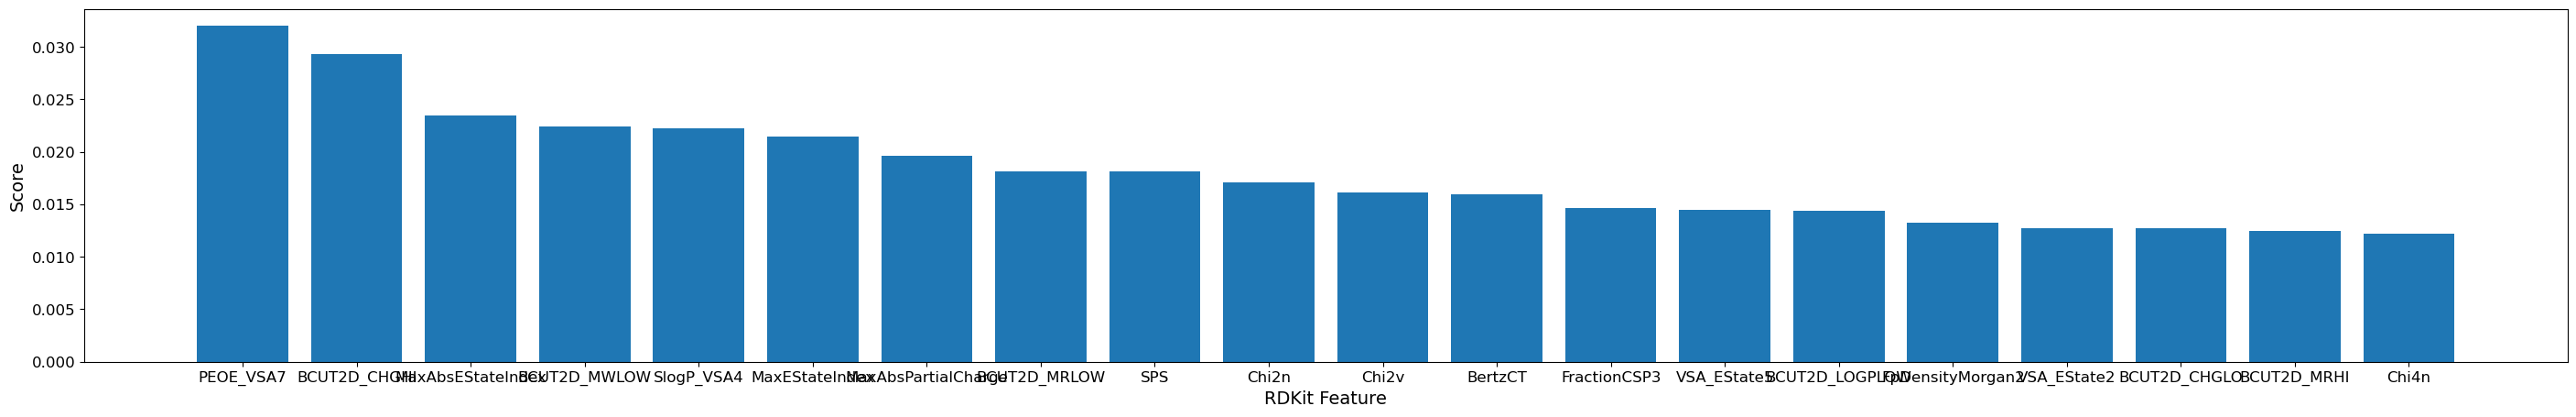

In [ ]:
#Here we print the top 10 factors. Explain these in the presentation.
names = []
scores = []
for i in range(20):
    (name, score) = sorted_tuple[i]
    names.append(name)
    scores.append(score)
    
plt.figure(figsize=(35,5))
plt.bar(names, scores)
plt.ylabel('Score')
plt.xlabel('RDKit Feature')
plt.show()

In [ ]:
#Let's fit model just against the top n features:
for lim in range(1,21):
    top_features = names[0:lim]
    X_top = pd.DataFrame()
    for col in top_features:
        X_top[col] = X[col]

    rnd_clf = RandomForestClassifier(random_state = 42)
    scores = cross_val_score(rnd_clf, X_top, y, cv=5)
    print("Top", lim, "features with mean: ", scores.mean()," and range: ", scores.std()**2)

Top 1 features with mean:  0.5728260869565217  and range:  0.005642722117202269
Top 2 features with mean:  0.657608695652174  and range:  0.0020439508506616254
Top 3 features with mean:  0.6619565217391304  and range:  0.0008908317580340264
Top 4 features with mean:  0.6869565217391306  and range:  0.0010113421550094512
Top 5 features with mean:  0.6891304347826087  and range:  0.002095935727788282
Top 6 features with mean:  0.6869565217391305  and range:  0.0027953686200378083
Top 7 features with mean:  0.7010869565217391  and range:  0.0015122873345935755
Top 8 features with mean:  0.6978260869565218  and range:  0.002204631379962195
Top 9 features with mean:  0.691304347826087  and range:  0.002474007561436674
Top 10 features with mean:  0.7000000000000001  and range:  0.002001417769376179
Top 11 features with mean:  0.7065217391304348  and range:  0.0006970699432892266
Top 12 features with mean:  0.7195652173913043  and range:  0.0009286389413988649
Top 13 features with mean:  0.70

In [ ]:
#Just want to check that the random forest on average gives a good score (and that the single model above wasn't a fluke)
#We fit a model 50 times with no set random state and also check the top contributing features.
scores_50 = []
for i in range(50):
    rank_store_50 = []
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    rnd2 = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)
    scores_50 += [rnd2.score(X_test, y_test)]
    for name, score in zip(X_test.columns, rnd2.feature_importances_):
        rank_store_50.append((name, score))
        sorted_tuple = sorted(
            rank_store_50, 
            key=lambda x: x[1],
            reverse=True)
    namedList = []
    for (name, score) in sorted_tuple[0:5]:
        namedList.append(name)
    print(namedList)
print(np.mean(scores_50), np.std(scores_50))

['PEOE_VSA7', 'SlogP_VSA4', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'BCUT2D_MWLOW']
['PEOE_VSA7', 'BCUT2D_MRLOW', 'SlogP_VSA4', 'MaxEStateIndex', 'BCUT2D_CHGHI']
['PEOE_VSA7', 'SlogP_VSA4', 'MaxEStateIndex', 'BCUT2D_MWLOW', 'MaxAbsEStateIndex']
['PEOE_VSA7', 'MaxAbsEStateIndex', 'VSA_EState8', 'BCUT2D_CHGHI', 'BCUT2D_LOGPHI']
['MaxEStateIndex', 'PEOE_VSA7', 'MaxAbsEStateIndex', 'BCUT2D_MRLOW', 'SlogP_VSA4']
['MaxEStateIndex', 'PEOE_VSA7', 'MaxAbsEStateIndex', 'BCUT2D_CHGHI', 'Chi2v']
['PEOE_VSA7', 'MaxAbsEStateIndex', 'BCUT2D_CHGHI', 'SlogP_VSA4', 'MaxEStateIndex']
['PEOE_VSA7', 'MaxEStateIndex', 'SlogP_VSA4', 'BCUT2D_MRLOW', 'VSA_EState2']
['PEOE_VSA7', 'SlogP_VSA4', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'BCUT2D_MWLOW']
['PEOE_VSA7', 'SlogP_VSA4', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'MaxEStateIndex']
['PEOE_VSA7', 'SlogP_VSA4', 'MaxEStateIndex', 'BCUT2D_MRLOW', 'Chi3n']
['MaxEStateIndex', 'PEOE_VSA7', 'SlogP_VSA4', 'MaxAbsEStateIndex', 'BCUT2D_CHGHI']
['PEOE_VSA7', 'MaxAbsEStateIndex', 'M

In [ ]:
#Let's build an ensemble method using the top 10 features:
X_top_10 = pd.DataFrame()

for col in names[0:10]:
    X_top_10[col] = X[col]
        
X_train, X_test, y_train, y_test = train_test_split(X_top_10, y, random_state=42)
stacking_clf = StackingClassifier(
    estimators = [
        ('rf', RandomForestClassifier(n_estimators = 100, random_state = 42)),
        ('svm', Pipeline([('scaler', StandardScaler()), ('svm_clf', SVC(kernel = 'rbf', gamma = 'auto'))])),
        ('mlp', MLPClassifier(max_iter = 1000, random_state = 42))
    ],
    final_estimator = RandomForestClassifier(n_estimators = 200, oob_score = True, random_state = 42)
)

stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
#Check model isn't overfitted by looking at the confusion matrix:
print(metrics.classification_report(y_test, y_pred))

0.8565217391304348
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       130
           1       0.83      0.85      0.84       100

    accuracy                           0.86       230
   macro avg       0.85      0.86      0.85       230
weighted avg       0.86      0.86      0.86       230



Using just 10 of the 200 features we get a model that is powerful.

In [ ]:
#Let's fit model on either test data (rather than test-train split) as we will need this in the next step:
stacking_clf = StackingClassifier(
    estimators = [
        ('rf', RandomForestClassifier(n_estimators = 100, random_state = 42)),
        ('svm', Pipeline([('scaler', StandardScaler()), ('svm_clf', SVC(kernel = 'rbf', gamma = 'auto'))])),
        ('mlp', MLPClassifier(max_iter = 1000, random_state = 42))
    ],
    final_estimator = RandomForestClassifier(n_estimators = 200, oob_score = True, random_state = 42)
)

stacking_clf.fit(X_top_10, y)

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svm',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('svm_clf',
                                                 SVC(gamma='auto'))])),
                               ('mlp',
                                MLPClassifier(max_iter=1000, random_state=42))],
                   final_estimator=RandomForestClassifier(n_estimators=200,
                                                          oob_score=True,
                                                          random_state=42))

Can we find a molecule that doesn't target the protein, but should be considered to?

In [ ]:
def moleculesNotTargetingProtein(proteinName):   
    #Get list of molecules targeting this protein:
    reduced_df = df[['BindingDB Ligand Name', 'Target Name', 'Ligand SMILES']]
    target_prot_list=reduced_df.loc[df['Target Name'] == proteinName]
    molecule_list = target_prot_list['Ligand SMILES']
    #Get list of all molecules we have a featurisation for and remove those from above.
    rdkit_descriptors = pd.read_csv('rdkit_descriptors.csv', header=0)
    filtered_rd_kit = rdkit_descriptors[~rdkit_descriptors['SMILES'].isin(molecule_list)]
    filtered_rd_kit = filtered_rd_kit.drop('Unnamed: 0', axis=1)
    filtered_rd_kit = pd.merge(filtered_rd_kit, reduced_df, left_on='SMILES', right_on='Ligand SMILES')
    filtered_rd_kit.drop(['SMILES', 'Ligand SMILES'], axis=1, inplace=True) 
    float64_cols = list(filtered_rd_kit.select_dtypes(include='float64'))
    # The same code again calling the columns
    filtered_rd_kit[float64_cols] = filtered_rd_kit[float64_cols].astype('float32')
    filtered_rd_kit.replace([-np.inf, np.inf], np.nan, inplace=True)
    filtered_rd_kit.dropna(inplace=True)
    filtered_rd_kit.drop_duplicates(subset=['BindingDB Ligand Name'], inplace=True)
    filtered_rd_kit.reset_index(drop=True, inplace=True)
    return filtered_rd_kit

In [ ]:
candidateMolecules = moleculesNotTargetingProtein('Dimer of Gag-Pol polyprotein [489-587]')

C:\Users\judge\anaconda3\Lib\site-packages\pandas\core\dtypes\astype.py:138: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


In [ ]:
#If we wish to use to the stacked method that works on only the top 10 features we need to extract only these features:
candidateMolecules_top_10 = pd.DataFrame()
for col in names[0:10]:
    candidateMolecules_top_10[col] = candidateMolecules[col]
#Get predictions for all of these and see if any have a value of 1.
results = stacking_clf.predict(candidateMolecules_top_10)
effectiveMolecules_dimer = []
for i in range(len(results)):
    if results[i] == 1:
        effectiveMolecules_dimer.append(candidateMolecules['BindingDB Ligand Name'][i])

In [ ]:
print("There are ", len(effectiveMolecules_dimer), "candidate molecules to target the protein")
print("Examples include:")
for i in range(5):
    print("Molecule", i+1, ":", effectiveMolecules_dimer[i])

There are  2729 candidate molecules to target the protein
Examples include:
Molecule 1 : BHAP deriv.::CHEMBL593::DELAVIRDINE MESYLATE::Delavirdine::N-[2-({4-[3-(propan-2-ylamino)pyridin-2-yl]piperazin-1-yl}carbonyl)-1H-indol-5-yl]methanesulfonamide::Rescriptor::U-90152S
Molecule 2 : Quinolone-based HDAC inhibitor 4t
Molecule 3 : Quinolone-based HDAC inhibitor 4v
Molecule 4 : MdnA8
Molecule 5 : CHEBI:84382::CHEMBL2426321::Chondramide C


## Target Protein: Coagulation Factor X

We look at the protein Coagulation Factor X. Let us define some helper functions first. They are joinRDKitFeatures(), which joins the binding data for a specific protein with the RDKit featurisation, and moleculesNotTargetingProtein(), which finds all the molecules in the database not targeting a given protein.

In [40]:
def joinRDKitFeatures(old_df, target_protein):
    temp_df=old_df.loc[old_df['Target Name'] == target_protein]
    rdkit_descriptors = pd.read_csv('rdkit_descriptors.csv', header=0)
    rdkit_descriptors.drop('Unnamed: 0', axis=1, inplace = True)
    rdkit_descriptors = pd.merge(rdkit_descriptors, temp_df, left_on='SMILES', right_on='Ligand SMILES')
    rdkit_descriptors.drop(['SMILES', 'Ligand SMILES', 'Target Name'], axis=1, inplace=True)   
    #We need to convert the float64 columns to float32 as random forest won't work on this.
    float64_cols = list(rdkit_descriptors.select_dtypes(include='float64'))
    # The same code again calling the columns
    rdkit_descriptors[float64_cols] = rdkit_descriptors[float64_cols].astype('float32')
    rdkit_descriptors.replace([-np.inf, np.inf], np.nan, inplace=True)
    rdkit_descriptors.dropna(inplace=True)
    return rdkit_descriptors

In [41]:
def moleculesNotTargetingProtein(proteinName):   
    #Get list of molecules targeting this protein:
    reduced_df = df[['BindingDB Ligand Name', 'Target Name', 'Ligand SMILES']]
    target_prot_list=reduced_df.loc[df['Target Name'] == proteinName]
    molecule_list = target_prot_list['Ligand SMILES']
    #Get list of all molecules we have a featurisation for and remove those from above.
    rdkit_descriptors = pd.read_csv('rdkit_descriptors.csv', header=0)
    filtered_rd_kit = rdkit_descriptors[~rdkit_descriptors['SMILES'].isin(molecule_list)]
    filtered_rd_kit = filtered_rd_kit.drop('Unnamed: 0', axis=1)
    filtered_rd_kit = pd.merge(filtered_rd_kit, reduced_df, left_on='SMILES', right_on='Ligand SMILES')
    filtered_rd_kit.drop(['SMILES', 'Ligand SMILES'], axis=1, inplace=True) 
    float64_cols = list(filtered_rd_kit.select_dtypes(include='float64'))
    # The same code again calling the columns
    filtered_rd_kit[float64_cols] = filtered_rd_kit[float64_cols].astype('float32')
    filtered_rd_kit.replace([-np.inf, np.inf], np.nan, inplace=True)
    filtered_rd_kit.dropna(inplace=True)
    filtered_rd_kit.drop_duplicates(subset=['BindingDB Ligand Name'], inplace=True)
    filtered_rd_kit.reset_index(drop=True, inplace=True)
    return filtered_rd_kit

We select all those molecules targeting Coagulation Factor X and merge with their RdKit featurisations.

In [42]:
protDF2 = createNewCategory(50,25)
coagDF = joinRDKitFeatures(protDF2, 'Coagulation factor X')
coagDF

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Effective
0,5.308148,5.308148,0.370926,0.370926,0.368870,8.888889,121.163002,112.091003,121.076027,46,...,0,0,0,0,0,0,0,0,0,0
1,5.308148,5.308148,0.370926,0.370926,0.368870,8.888889,121.163002,112.091003,121.076027,46,...,0,0,0,0,0,0,0,0,0,0
2,13.660512,13.660512,0.073015,-1.030013,0.057408,12.804348,689.669983,651.366028,688.211365,246,...,0,0,0,0,1,0,0,1,1,0
3,13.857789,13.857789,0.083912,-1.140415,0.035288,13.200000,706.869995,660.502014,706.326111,268,...,0,0,0,0,1,0,0,1,1,0
4,13.744537,13.744537,0.079871,-1.110485,0.042124,13.510638,672.853027,624.468994,672.341736,258,...,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,14.929046,14.929046,0.049070,-3.553094,0.509605,15.583333,529.976990,508.808990,529.087463,186,...,0,1,0,0,0,0,0,0,1,1
225,14.923210,14.923210,0.001587,-3.598031,0.441900,16.891891,551.973999,530.806030,551.089355,194,...,0,1,0,0,0,0,0,0,1,1
226,14.938335,14.938335,0.032999,-3.549307,0.460740,17.611111,532.981018,510.804993,532.098328,188,...,0,1,0,0,0,0,0,0,1,1
227,15.029200,15.029200,0.069056,-3.540041,0.478197,17.459459,547.007996,522.815979,546.114014,194,...,0,1,0,0,0,0,0,0,1,1


In [43]:
#Build Random Forest Model
X = coagDF.iloc[:,:-1]
y = coagDF['Effective']
# Build a RF
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
rnd_clf = RandomForestClassifier(random_state = 42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
print(metrics.accuracy_score(y_pred_rf, y_test))
print(metrics.classification_report(y_test, y_pred_rf))

0.8448275862068966
              precision    recall  f1-score   support

           0       0.80      0.97      0.88        33
           1       0.94      0.68      0.79        25

    accuracy                           0.84        58
   macro avg       0.87      0.82      0.83        58
weighted avg       0.86      0.84      0.84        58



In [44]:
#We look at the top 20 features.
coag_feature_importances = pd.Series(rnd_clf.feature_importances_, index=X.columns)
coag_top_20_features = coag_feature_importances.nlargest(20)
coag_top_20_features

BalabanJ                    0.045484
NumAliphaticHeterocycles    0.034932
SPS                         0.030312
RingCount                   0.028246
SMR_VSA6                    0.027140
BCUT2D_CHGHI                0.021985
NumSaturatedRings           0.021519
EState_VSA4                 0.018897
FpDensityMorgan3            0.018198
BCUT2D_LOGPLOW              0.016141
PEOE_VSA6                   0.016051
SlogP_VSA1                  0.015910
NumRotatableBonds           0.015822
PEOE_VSA7                   0.015133
Chi4n                       0.014633
SlogP_VSA2                  0.014384
NHOHCount                   0.014345
NumAliphaticRings           0.014092
BCUT2D_MRLOW                0.013635
Chi3v                       0.013353
dtype: float64

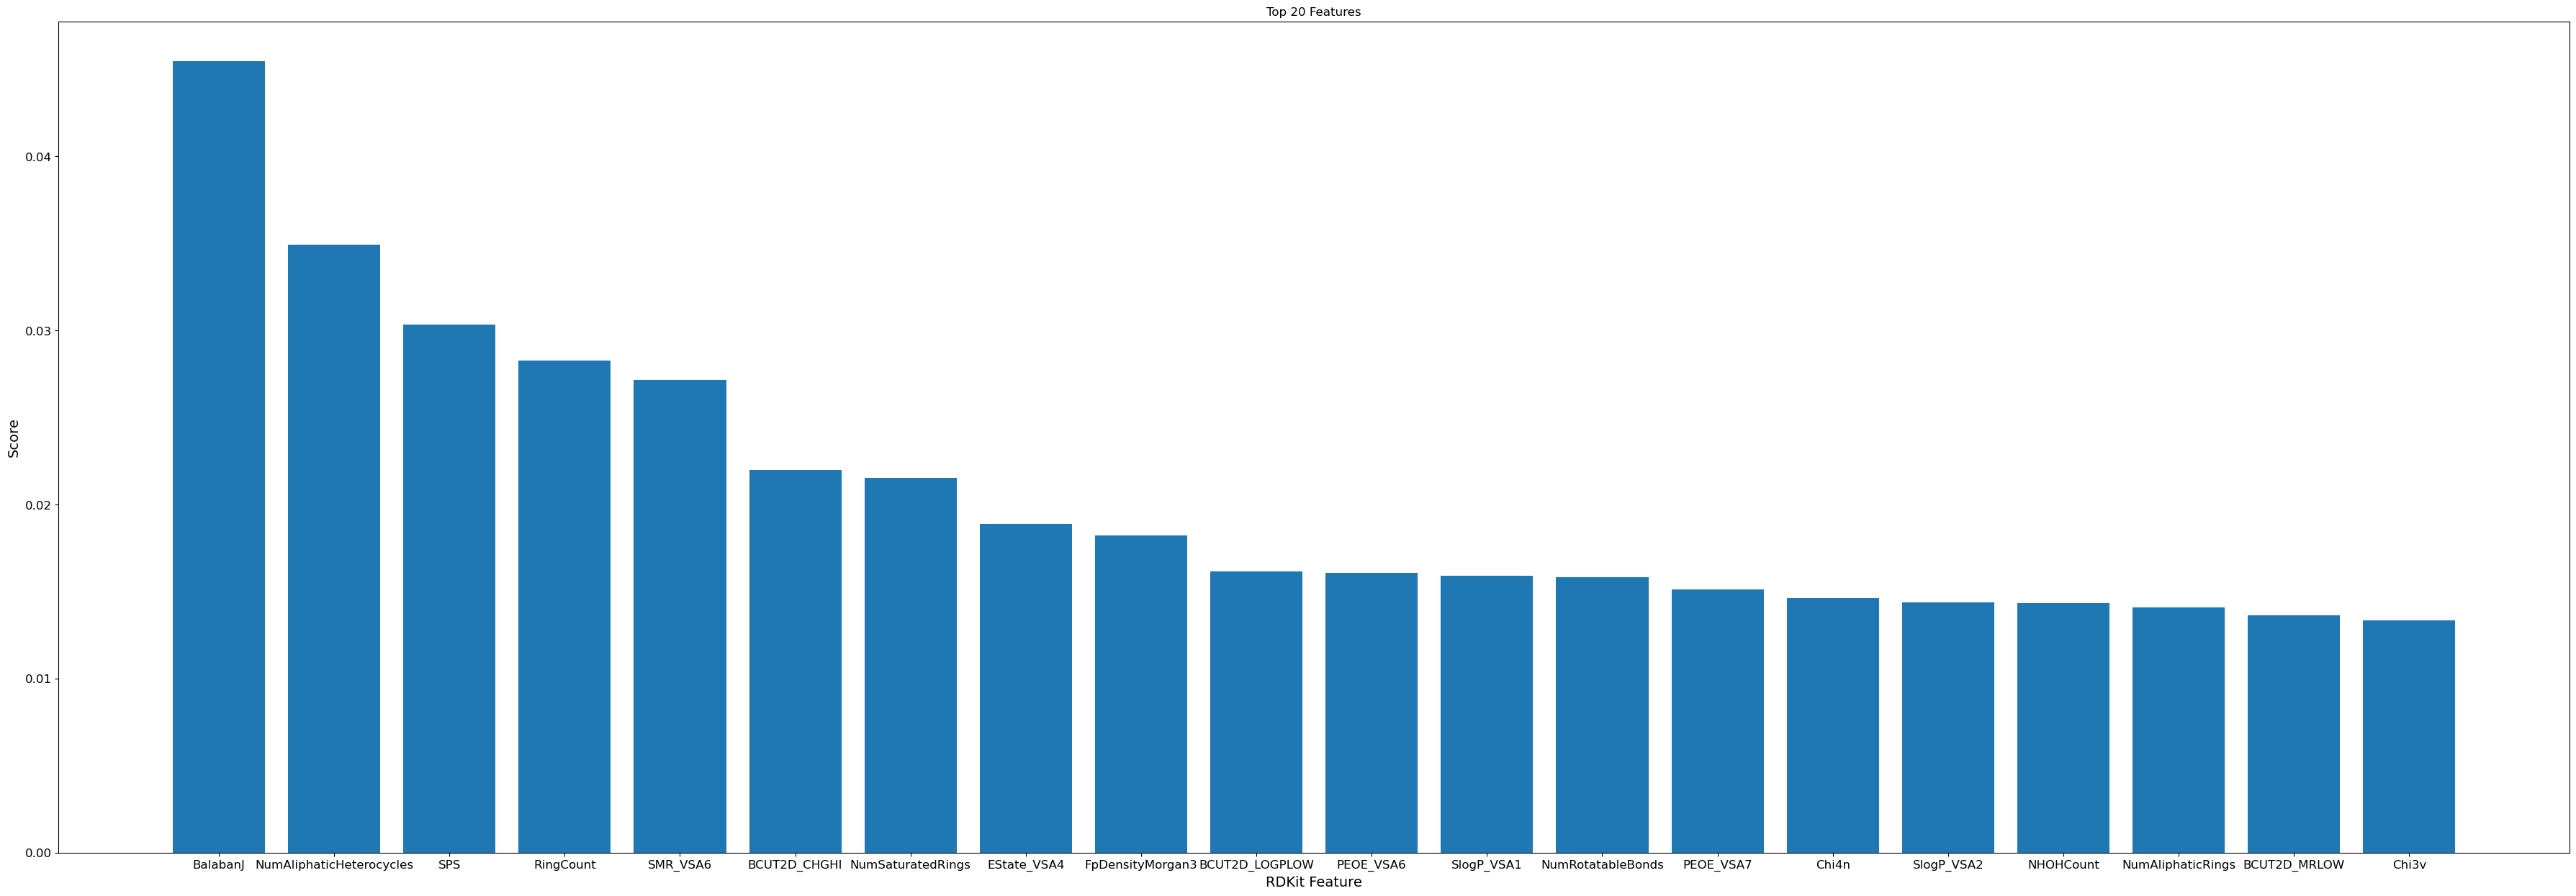

In [45]:
#Here we print the top 10 factors. Explain these in the presentation.
fig = plt.figure(figsize=(45,15))
plt.bar(coag_top_20_features.index, coag_top_20_features.values)
plt.ylabel('Score')
plt.xlabel('RDKit Feature')
plt.title('Top 20 Features')
plt.show()
fig.savefig('test.png', bbox_inches='tight')

In [46]:
#Let's fit model just against the top n features for n from 1 to 20 so we can see how model performance varies 
#with each new feature:
for lim in range(1,21):
    top_features = coag_top_20_features.index[0:lim]
    X_top = pd.DataFrame()
    for col in top_features:
        X_top[col] = X[col]

    rnd_clf = RandomForestClassifier(random_state = 42)
    scores = cross_val_score(rnd_clf, X_top, y, cv=5)
    print("Top", lim, "features with mean: ", scores.mean()," and range: ", scores.std()**2)

Top 1 features with mean:  0.6327536231884057  and range:  0.00821306448225163
Top 2 features with mean:  0.5802898550724638  and range:  0.0096547784078975
Top 3 features with mean:  0.5847342995169083  and range:  0.008156699106163503
Top 4 features with mean:  0.6020289855072465  and range:  0.011645956731779039
Top 5 features with mean:  0.6107246376811595  and range:  0.014521823146397817
Top 6 features with mean:  0.6020289855072465  and range:  0.013347279983196809
Top 7 features with mean:  0.615169082125604  and range:  0.01388742794464282
Top 8 features with mean:  0.5932367149758454  and range:  0.017065975868748393
Top 9 features with mean:  0.5752657004830917  and range:  0.03360698266003874
Top 10 features with mean:  0.6019323671497585  and range:  0.02255221825480174
Top 11 features with mean:  0.6107246376811595  and range:  0.023406511237135046
Top 12 features with mean:  0.5531400966183575  and range:  0.04502788863217345
Top 13 features with mean:  0.571111111111111

In [47]:
#Just want to check that the random forest on average gives a good score (and that the single model above wasn't a fluke)
#We fit a model 50 times with no set random state and also check the top contributing features. Although the top contributing 
#features vary slightly, we see there is some consistency.
scores_50 = []
for i in range(50):
    rank_store_50 = []
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    rnd2 = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)
    scores_50 += [rnd2.score(X_test, y_test)]
    coag_feature_importances_temp = pd.Series(rnd2.feature_importances_, index=X.columns)
    names_temp = []
    for col_name in coag_feature_importances_temp.nlargest(5).index:
        names_temp.append(col_name)
    print(names_temp)
print(np.mean(scores_50), np.std(scores_50))

['NumAliphaticHeterocycles', 'SPS', 'RingCount', 'NumAliphaticRings', 'SMR_VSA6']
['BalabanJ', 'NumSaturatedRings', 'PEOE_VSA6', 'SPS', 'NumAliphaticHeterocycles']
['BalabanJ', 'NumAliphaticRings', 'NumAliphaticHeterocycles', 'SMR_VSA6', 'SPS']
['NumAliphaticRings', 'SPS', 'PEOE_VSA6', 'BalabanJ', 'RingCount']
['BalabanJ', 'RingCount', 'SMR_VSA6', 'AvgIpc', 'NumAliphaticHeterocycles']
['NumAliphaticHeterocycles', 'NumAliphaticRings', 'BalabanJ', 'SMR_VSA6', 'NumSaturatedRings']
['BalabanJ', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumSaturatedRings', 'PEOE_VSA6']
['BalabanJ', 'NumSaturatedRings', 'SMR_VSA6', 'NumAliphaticHeterocycles', 'NumAliphaticRings']
['RingCount', 'SPS', 'NumAliphaticRings', 'SMR_VSA6', 'NumAliphaticHeterocycles']
['SPS', 'BalabanJ', 'NumAliphaticRings', 'NumAliphaticHeterocycles', 'NumSaturatedRings']
['BalabanJ', 'SPS', 'NumAliphaticHeterocycles', 'PEOE_VSA6', 'SMR_VSA6']
['BalabanJ', 'NumAliphaticHeterocycles', 'RingCount', 'VSA_EState4', 'SPS']
['SMR

The top features vary slightly, but we see that BalabanJ, SMR_VSA6, SPS and RingCount appear and therefore are justified in sticking with the initial top 10 features from a few cells ago.

In [48]:
#Let's build an ensemble method using the top 10 features:
X_top_10 = pd.DataFrame()

for col in coag_top_20_features.index[0:10]:
    X_top_10[col] = X[col]
X_train, X_test, y_train, y_test = train_test_split(X_top_10, y, random_state=42)
stacking_clf = StackingClassifier(
    estimators = [
        ('rf', RandomForestClassifier(n_estimators = 100, random_state = 42)),
        ('svm', Pipeline([('scaler', StandardScaler()), ('svm_clf', SVC(kernel = 'rbf', gamma = 'auto'))])),
        ('mlp', MLPClassifier(max_iter = 1000, random_state = 42))
    ],
    final_estimator = RandomForestClassifier(n_estimators = 200, random_state = 42)
)

stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
#Check model isn't overfitted by looking at the confusion matrix:
print(metrics.classification_report(y_test, y_pred))

0.7586206896551724
              precision    recall  f1-score   support

           0       0.87      0.73      0.79        37
           1       0.63      0.81      0.71        21

    accuracy                           0.76        58
   macro avg       0.75      0.77      0.75        58
weighted avg       0.78      0.76      0.76        58



In [49]:
#Let's fit model on entire test data (rather than test-train split) as we will need this in the next step:
stacking_clf = StackingClassifier(
    estimators = [
        ('rf', RandomForestClassifier(n_estimators = 100, random_state = 42)),
        ('svm', Pipeline([('scaler', StandardScaler()), ('svm_clf', SVC(kernel = 'rbf', gamma = 'auto'))])),
        ('mlp', MLPClassifier(max_iter = 1000, random_state = 42))
    ],
    final_estimator = RandomForestClassifier(n_estimators = 200, random_state = 42)
)

stacking_clf.fit(X_top_10, y)

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svm',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('svm_clf',
                                                 SVC(gamma='auto'))])),
                               ('mlp',
                                MLPClassifier(max_iter=1000, random_state=42))],
                   final_estimator=RandomForestClassifier(n_estimators=200,
                                                          random_state=42))

We now apply the above model to all those molecules in the BindingDB that are not already targeting Coagulation Factor X and see if any might make good candidates. The moleculesNotTargetingProtein() function is used to select all of the non-coagulation factor X targeting molecules.

In [50]:
candidateMolecules = moleculesNotTargetingProtein('Coagulation factor X')

C:\Users\judge\anaconda3\Lib\site-packages\pandas\core\dtypes\astype.py:170: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


In [51]:
#If we wish to use to the stacked method that works on only the top 10 features we need to extract only these features:
candidateMolecules_top_10 = pd.DataFrame()
for col in coag_top_20_features.index[0:10]:
    candidateMolecules_top_10[col] = candidateMolecules[col]
#Get predictions for all of these and see if any have a value of 1.
results = stacking_clf.predict(candidateMolecules_top_10)
effectiveMolecules_coag = []
for i in range(len(results)):
    if results[i] == 1:
        effectiveMolecules_coag.append(candidateMolecules['BindingDB Ligand Name'][i])

In [52]:
print("There are ", len(effectiveMolecules_coag), "candidate molecules to target the protein")
print("Examples include:")
for i in range(100):
    print("Molecule", i+1, ":", effectiveMolecules_coag[i])

There are  15774 candidate molecules to target the protein
Examples include:
Molecule 1 : 3-quinolinecarbonitrile 8::4-[(2,4-dichloro-5-methoxyphenyl)amino]-6,7-bis(2-methoxyethoxy)quinoline-3-carbonitrile
Molecule 2 : 3-quinolinecarbonitrile 9::4-[(2,4-dichlorophenyl)amino]-6,7-bis(2-methoxyethoxy)quinoline-3-carbonitrile
Molecule 3 : 3-quinolinecarbonitrile 10::6,7-bis(2-methoxyethoxy)-4-[(3,4,5-trimethoxyphenyl)amino]quinoline-3-carbonitrile
Molecule 4 : 3-quinolinecarbonitrile 13::4-[(2,4-dichloro-5-methoxyphenyl)amino]-6-methoxy-7-(2-methoxyethoxy)quinoline-3-carbonitrile
Molecule 5 : 3-quinolinecarbonitrile 15::4-[(2,4-dichlorophenyl)amino]-6-methoxy-7-(2-methoxyethoxy)quinoline-3-carbonitrile
Molecule 6 : 3-quinolinecarbonitrile 16::6-methoxy-7-(2-methoxyethoxy)-4-[(3,4,5-trimethoxyphenyl)amino]quinoline-3-carbonitrile
Molecule 7 : 3-quinolinecarbonitrile 18::4-[(2,4-Dichloro-5-methoxyphenyl)amino]-6-methoxy-7-[(1-methylpiperidin-4-yl)methoxy]-3-quinolinecarbonitrile::4-[(2,4-di

In [53]:
#A short list of good candidate molecules to show for the presentation
some_values = ['SmNACE inhibitor, 1', 'eIF4A3 inhibitor, 1', 'MdnA3', 'Rifampicin::cid_5381226']
short_list = candidateMolecules[['BindingDB Ligand Name', 'Target Name','BalabanJ', 'SPS', 'RingCount', 'NumAliphaticHeterocycles', 'SMR_VSA6', 'PEOE_VSA6']]
short_list.loc[short_list['BindingDB Ligand Name'].isin(some_values)]

,BindingDB Ligand Name,Target Name,BalabanJ,SPS,RingCount,NumAliphaticHeterocycles,SMR_VSA6,PEOE_VSA6
61,MdnA3,Serine protease 1,1.318730,24.826086,8,4,26.241152,56.312042
65,"eIF4A3 inhibitor, 1",Eukaryotic initiation factor 4A-III,1.403934,15.771428,5,1,19.634270,53.533714
70,"SmNACE inhibitor, 1",ADP-ribosyl cyclase/cyclic ADP-ribose hydrolase,2.019858,10.789474,2,0,0.000000,0.000000
79,Rifampicin::cid_5381226,Ubiquitin carboxyl-terminal hydrolase isozyme L1,1.661818,34.067795,6,4,40.336494,45.923008


## Appendix

We will attempt to fit a GNN and see if this makes a good model. Used these articles as inspiration: https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/ and https://projects.volkamerlab.org/teachopencadd/talktorials/T035_graph_neural_networks.html

In [54]:
def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """

    if x not in permitted_list:
        x = permitted_list[-1]

    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

    return binary_encoding

def get_atom_features(atom, 
                      use_chirality = True, 
                      hydrogens_implicit = True):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """

    # define list of permitted atoms
    
    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
    
    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms
    
    # compute atom features
    
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    
    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    
    is_in_a_ring_enc = [int(atom.IsInRing())]
    
    is_aromatic_enc = [int(atom.GetIsAromatic())]
    
    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]
    
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
                                    
    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
    
    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)

def get_bond_features(bond, 
                      use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc
    
    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)

def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(smile_column, category_column):
    """
    Inputs:
    
    x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
    y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)
    
    Outputs:
    
    data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning
    
    """
    x_smiles = smile_column.tolist()
    y =category_column.tolist()
    data_list = []
    
    for (smiles, y_val) in zip(x_smiles, y):
        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)
        if mol == None: continue
        # get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_edges = 2*mol.GetNumBonds()
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))
        # construct node feature matrix X of shape (n_nodes, n_node_features)
        X = np.zeros((n_nodes, n_node_features))
        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)
            
        X = torch.tensor(X, dtype = torch.float)
        
        # construct edge index array E of shape (2, n_edges)
        (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
        torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
        torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
        E = torch.stack([torch_rows, torch_cols], dim = 0)
        
        # construct edge feature array EF of shape (n_edges, n_edge_features)
        EF = np.zeros((n_edges, n_edge_features))
        
        for (k, (i,j)) in enumerate(zip(rows, cols)):
            
            EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))
        
        EF = torch.tensor(EF, dtype = torch.float)
        
        # construct label tensor
        y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)
        
        # construct Pytorch Geometric data object and append to data list
        data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor))
    return data_list

In [55]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch_geometric.nn.conv.GCNConv(79, 20)
        self.conv2 = torch_geometric.nn.conv.GCNConv(20, 20)
        self.conv3 = torch_geometric.nn.conv.GCNConv(20, 20)
        self.lin = torch.nn.Linear(20, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data):
        e = data.edge_index
        x = data.x

        x = self.conv1(x, e)
        x = x.relu()
        x = self.conv2(x, e)
        x = x.relu()
        x = self.conv3(x, e)
        x = torch_geometric.nn.pool.global_mean_pool(x, data.batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.sigmoid(self.lin(x))
        
        return x

In [56]:
protDF_gnn = createNewCategory(10,5)
gag_df=protDF_gnn.loc[protDF_gnn['Target Name'] == 'Dimer of Gag-Pol polyprotein [489-587]']
data_list = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(gag_df['Ligand SMILES'], gag_df['Effective'])
gnn_model=GCN()

In [57]:
# create dataloader for training
train = data_list[200:]
test=data_list[0:200]
dataloader = DataLoader(dataset = train, batch_size=100)
dataloader_test = DataLoader(dataset = test, batch_size=1)
loss_function = torch.nn.BCELoss()
optimiser = torch.optim.Adam(gnn_model.parameters(), lr = 0.01)
for epoch in range(100):
    for (k, batch) in enumerate(dataloader):
        # compute current value of loss function via forward pass
        output = gnn_model(batch)
        loss_function_value = loss_function(output[:,0], torch.tensor(batch.y, dtype = torch.float32))
        # set past gradient to zero
        optimiser.zero_grad()
        # compute current gradient via backward pass
        loss_function_value.backward()
        # update model weights using gradient and optimisation method
        optimiser.step()

C:\Users\judge\AppData\Local\Temp\ipykernel_10796\3879099259.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_function_value = loss_function(output[:,0], torch.tensor(batch.y, dtype = torch.float32))


In [58]:
gnn_model.eval()
pred_total = []
for batch in dataloader_test:
    pred = gnn_model(batch)
    correct = (round(pred[0].item()) == batch.y).sum()
    pred_total.append(int(correct))
    print(pred[0].item())
print(f'Accuracy: {sum(pred_total)/len(pred_total):.4f}')

0.030955391004681587
0.1131557747721672
0.10168174654245377
0.11573972553014755
0.2075350433588028
0.2808955907821655
0.08265408873558044
0.26720064878463745
0.17932520806789398
0.28581222891807556
0.20117677748203278
0.09150931239128113
0.38264742493629456
0.3625728189945221
0.387474000453949
0.30159762501716614
0.21473893523216248
0.12456617504358292
0.15708868205547333
0.2283163070678711
0.22818514704704285
0.12708024680614471
0.14377246797084808
0.0983508825302124
0.14073172211647034
0.11300443857908249
0.17668193578720093
0.1553889513015747
0.21117202937602997
0.21110370755195618
0.1593324989080429
0.2094707489013672
0.26664337515830994
0.1104210764169693
0.18288180232048035
0.03821569308638573
0.0967308059334755
0.06552430987358093
0.09194891899824142
0.07898178696632385
0.07294414937496185
0.06708338856697083
0.06179876625537872
0.07294414937496185
0.06708338856697083
0.06179876625537872
0.05835200101137161
0.06488890200853348
0.12070206552743912
0.1095673218369484
0.06527870893